In [2]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import h5py
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.filters import gaussian_filter1d
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
from matplotlib import colors

%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import itertools
import random
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
import matplotlib.patches as patches

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from scipy.fftpack import fft,fftshift,ifft
from scipy import signal
import pickle
from tqdm import tqdm
from shutil import copyfile
import cv2

from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation

import colorsys
from scipy import stats

In [3]:
### Load Luke Mean ###

luke_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20210310_luke_exp_thresh.nii"
res_luke_mean = (0.65,0.65,1)
luke_mean = np.asarray(nib.load(luke_path).get_data().squeeze(), dtype='float32')
luke_mean = luke_mean[:,:,::-1] #flipz
luke_mean = ants.from_numpy(luke_mean)
luke_mean.set_spacing(res_luke_mean)
luke_mean_lowres =  ants.resample_image(luke_mean,(256,128,49),use_voxels=True)

In [ ]:
### Load JFRC2018 ###

fixed_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/JRC2018_FEMALE_38um_iso_16bit.nii"
res_JRC2018 = (0.38, 0.38, 0.38)
fixed = np.asarray(nib.load(fixed_path).get_data().squeeze(), dtype='float32')
fixed = ants.from_numpy(fixed)
fixed.set_spacing(res_JRC2018)
fixed_lowres = ants.resample_image(fixed,(2.6,2.6,5),use_voxels=False)

In [ ]:
fixed_lowres

In [ ]:
1

In [ ]:
##################
### Unique GLM ###
##################

### Load supervoxel labels ###
n_clusters = 2000
labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/cluster_labels.npy'
cluster_model_labels = np.load(labels_file)

### load glm ###
main_dir = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210208_inst_uniq_glm/'
all_scores = []
for z in range(49):
    file = [os.path.join(main_dir, i) for i in os.listdir(main_dir) if f'Z{z}.' in i][0]
    with open(file, 'rb') as handle:
        scores = pickle.load(handle)
    all_scores.append(scores)
    
uniques = ['scores_ypos_unique', 'scores_zpos_unique', 'scores_zneg_unique']
maps = {}

for unique in uniques:
    all_colored_by_betas = []
    for z in range(49):
        colored_by_betas = np.zeros(256*128)
        for cluster_num in range(len(np.unique(cluster_model_labels[z]))):
            cluster_indicies = np.where(cluster_model_labels[z]==cluster_num)[0]
            colored_by_betas[cluster_indicies] = all_scores[z]['scores_all'][cluster_num] - all_scores[z][unique][cluster_num]

            if len(cluster_indicies) > 100:
                colored_by_betas[cluster_indicies] = 0
            if colored_by_betas[cluster_indicies][0] == 1:
                colored_by_betas[cluster_indicies] = 0
        colored_by_betas = colored_by_betas.reshape(256,128)
        all_colored_by_betas.append(colored_by_betas)
    all_colored_by_betas = np.asarray(all_colored_by_betas)
    maps[unique] = all_colored_by_betas
    
############################################
### Put into plotting format with colors ###
############################################

slices = []
for z in range(49):
    colors1 = maps['scores_zneg_unique'][z,:,:].T
    colors2 = maps['scores_zpos_unique'][z,:,:].T
    colors3 = maps['scores_ypos_unique'][z,:,:].T
    to_plot = np.stack((colors1,colors2,colors3),axis=2)
    slices.append(to_plot)
slices = np.asarray(slices)
func = np.swapaxes(slices, 0, 2)
moving = ants.from_numpy(func[:,:,::-1,:])
moving.shape

In [ ]:
moving.set_spacing((2.6076, 2.6154, 5.3125, 1)) ### matching this to the slightly off luke mean

In [ ]:
out = ants.registration(fixed_lowres, luke_mean_lowres, type_of_transform='Affine')

In [ ]:
maps_voxel_res = ants.apply_transforms(fixed_lowres, moving, out['fwdtransforms'][0], imagetype=3, interpolator='nearestNeighbor')

In [ ]:
corr_map = maps_voxel_res.numpy()

In [ ]:
corr_map.shape

In [ ]:
def load_FDA():
    FDA_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20220301_luke_2_jfrc_affine.nii'
    FDA = np.asarray(nib.load(FDA_file).get_fdata().squeeze(), dtype='float32')
    FDA = ants.from_numpy(FDA)
    FDA.set_spacing((.38,.38,.38))
    FDA_lowres = ants.resample_image(FDA,(2.6,2.6,5),use_voxels=False)
    return FDA, FDA_lowres

FDA, FDA_lowres = load_FDA()

In [ ]:
FDA_lowres.shape

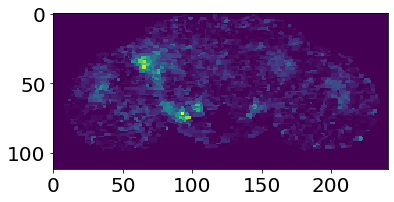

In [70]:
plt.imshow(corr_map[:,:,25,1].T)

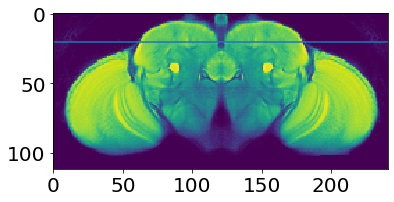

In [71]:
plt.imshow(FDA_lowres[:,:,23].T)
plt.axhline(20)

In [ ]:
##################
### Load Atlas ###
##################

atlas_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/jfrc_2018_rois_improve_reorient_transformed.nii"
atlas = np.asarray(nib.load(atlas_path).get_data().squeeze(), dtype='float32')

In [ ]:
atlas_int = np.rint(atlas)
atlas_clean = np.copy(atlas_int)
diff_atlas = atlas_int - atlas
thresh = 0.001
atlas_clean[np.where(np.abs(diff_atlas)>thresh)] = 0

In [ ]:
atlas = ants.from_numpy(atlas_clean)
atlas.set_spacing((.76,.76,.76))
atlas = ants.resample_image(atlas,(241, 112, 36),use_voxels=True)

In [ ]:
atlas.shape

In [ ]:
plt.imshow(atlas[:,:,23].T)

In [ ]:
# hemibrain bounding box
start = {'x': 46, 'y': 5, 'z': 5}
stop = {'x': 147, 'y': 89, 'z': 34}

In [ ]:
FDA_crop = FDA_lowres[start['x']:stop['x'],
                     start['y']:stop['y'],
                     start['z']:stop['z']]

atlas_crop = atlas[start['x']:stop['x'],
                  start['y']:stop['y'],
                  start['z']:stop['z']]

unique_crop = corr_map[start['x']:stop['x'],
                  start['y']:stop['y'],
                  start['z']:stop['z'],:]
#unique_crop = unique_crop[...,0] #pick corr type here

In [ ]:
dim_c = {'x': FDA_crop.shape[0],
         'y': FDA_crop.shape[1],
         'z': FDA_crop.shape[2]}

In [ ]:
n_clusters = 3000
clustering_dir = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20220624_supervoxels_in_FDA"
save_file = os.path.join(clustering_dir, '20220701_cluster_labels_flat_3000.npy')
labels_flat = np.load(save_file)
labels_3d = np.reshape(labels_flat,(dim_c['x'],dim_c['y'],dim_c['z']))

cluster_sizes = []
for cluster in range(n_clusters):
    cluster_sizes.append(len(np.where(labels_flat==cluster)[0]))
background_cluster = np.argmax(cluster_sizes)

labels_3d = labels_3d.astype('float32')
labels_3d[np.where(labels_3d==background_cluster)] = np.nan

#now that we removed background cluster, lets give it to 0 so we can get rid of "0" as well
labels_3d[np.where(labels_3d==0)] = background_cluster
labels_flat = labels_3d.flatten()

In [ ]:
save_dir = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20220624_supervoxels_in_FDA'
save_file = os.path.join(save_dir, 'adjacent_supervoxel_new.h5')

with h5py.File(save_file, 'r') as f:
    #print(list(f.keys()))
    adj = f['adjacent_supervoxel_new'][:]
    
# Feng removed the "0" entry so adding back
adj = np.pad(adj, (1,0), 'constant', constant_values=(0))

# Symmeterize
#adj = (adj + adj.T) / 2

In [ ]:
def clusters_to_3d(neural_signals):
    colored = np.zeros((dim_c['x']*dim_c['y']*dim_c['z']))
    for cluster_num in range(n_clusters):
        cluster_indicies = np.where(labels_flat==cluster_num)[0]
        colored[cluster_indicies] = neural_signals[cluster_num]
    colored = np.reshape(colored,(dim_c['x'],dim_c['y'],dim_c['z']))
    return colored

In [57]:
atlas_ids = [0] # cluster_num 0 doesn't exist in labels_3d
fwd_score = [0]
for cluster_num in range(1, n_clusters):
    indicies = np.where(labels_3d==cluster_num)
    
    atlas_roi_list = atlas_crop[indicies]
    atlas_id = int(stats.mode(atlas_roi_list)[0])
    
    ### only consider clusters that do not include more than 1 atlas roi ###
    # (0 is ok, so <3)
    if len(np.unique(atlas_roi_list)) < 3:
        atlas_ids.append(atlas_id)
        fwd_score.append(np.mean(unique_crop[indicies]))
    else:
        atlas_ids.append(0)
        fwd_score.append(0)
atlas_ids = np.asarray(atlas_ids)
fwd_score = np.asarray(fwd_score)

In [48]:
atlas_ids = [0] # cluster_num 0 doesn't exist in labels_3d
fwd_score = [0]
for cluster_num in range(1, n_clusters):
    indicies = np.where(labels_3d==cluster_num)
    
    atlas_roi_list = atlas_crop[indicies]
    atlas_id = int(stats.mode(atlas_roi_list)[0])
    
    ### only consider clusters that do not include more than 1 atlas roi ###
    # (0 is ok, so <3)
    #if len(np.unique(atlas_roi_list)) < 3:
    atlas_ids.append(atlas_id)
    fwd_score.append(np.mean(unique_crop[indicies]))
#     else:
#         atlas_ids.append(0)
#         fwd_score.append(0)
atlas_ids = np.asarray(atlas_ids)
fwd_score = np.asarray(fwd_score)

In [ ]:
atlas_ids

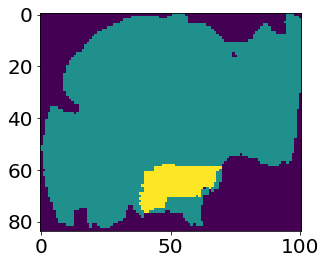

In [63]:
roi_id_from=38
to_color = np.zeros((3000))
to_color[:]=.5
to_color[atlas_ids == roi_id_from] = 1
out = clusters_to_3d(to_color)
plt.imshow(np.max(out,axis=2).T)

In [150]:
roi_id_from=33#8#38#7#33plp
#28: 'SIP_R',
sub_adj1 = adj[atlas_ids == roi_id_from,:]
sub_adj2 = adj[:,atlas_ids == roi_id_from]
sub_adj1.shape, sub_adj2.shape

((64, 3000), (3000, 64))

In [151]:
to_cluster = np.concatenate((sub_adj1, sub_adj2.T),axis=1)

In [154]:
cluster_model = AgglomerativeClustering(n_clusters=4,
                                memory=save_dir,
                                linkage='ward')
cluster_model.fit(to_cluster)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward',
                        memory='/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20220624_supervoxels_in_FDA',
                        n_clusters=4)

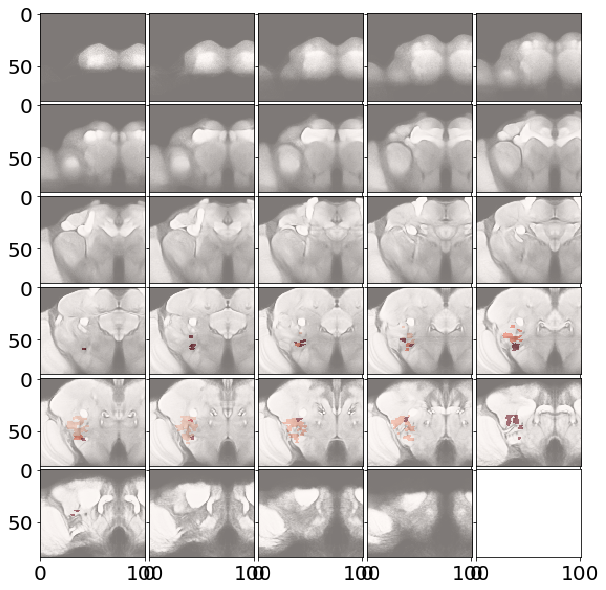

In [156]:
to_color = np.zeros((3000))
to_color[atlas_ids == roi_id_from] = cluster_model.labels_ + 1
out = clusters_to_3d(to_color)

fig = plt.figure(figsize=(20,10))
grid = ImageGrid(fig, 111, nrows_ncols=(6, 5), axes_pad=.05)
for z in range(29):
    grid[z].imshow(FDA_crop[:,:,z].T,cmap='Greys_r')
    grid[z].imshow(out[:,:,z].T, alpha=.5, cmap='Reds')

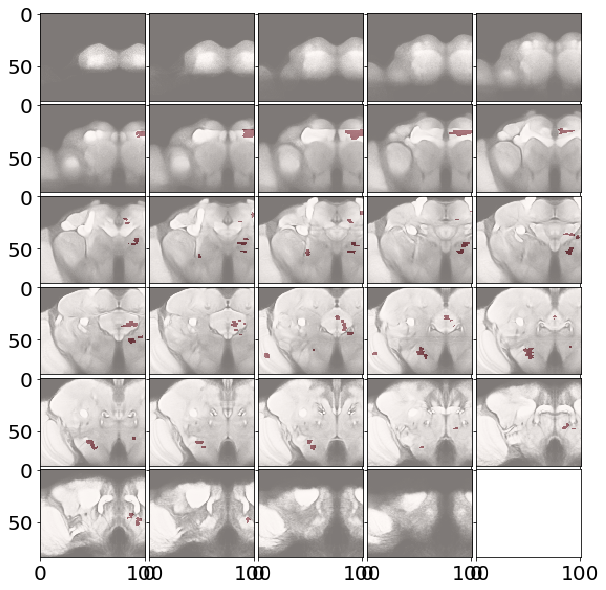

In [72]:
to_color = np.zeros((3000))
to_color[beh_scores['R']>.01] = 1
out = clusters_to_3d(to_color)

fig = plt.figure(figsize=(20,10))
grid = ImageGrid(fig, 111, nrows_ncols=(6, 5), axes_pad=.05)
for z in range(29):
    grid[z].imshow(FDA_crop[:,:,z].T,cmap='Greys_r')
    grid[z].imshow(out[:,:,z].T, alpha=.5, cmap='Reds')

In [137]:
to_color = np.zeros((3000))
to_color[atlas_ids == roi_id_from] = cluster_model.labels_ + 1
out1 = clusters_to_3d(to_color)

to_color = np.zeros((3000))
to_color[beh_scores['R']>.005] = 1
out2 = clusters_to_3d(to_color)

to_color = np.zeros((3000))
to_color[beh_scores['L']>.005] = 1
out3 = clusters_to_3d(to_color)

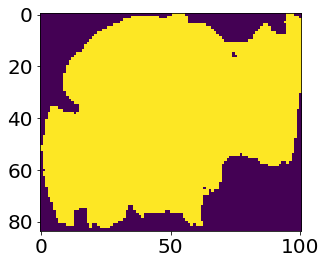

In [301]:
hemi_vol = clusters_to_3d(np.ones((3000)))
plt.imshow(np.max(hemi_vol,axis=2).T)

In [304]:
np.sum(out2), np.sum(out3)

(6907.0, 10584.0)

In [302]:
np.sum(hemi_vol)

75835.0

In [282]:
np.sum(np.logical_and(DN_crop>0, out2))

36

In [284]:
np.sum(np.logical_and(DN_crop>0, out3))

80

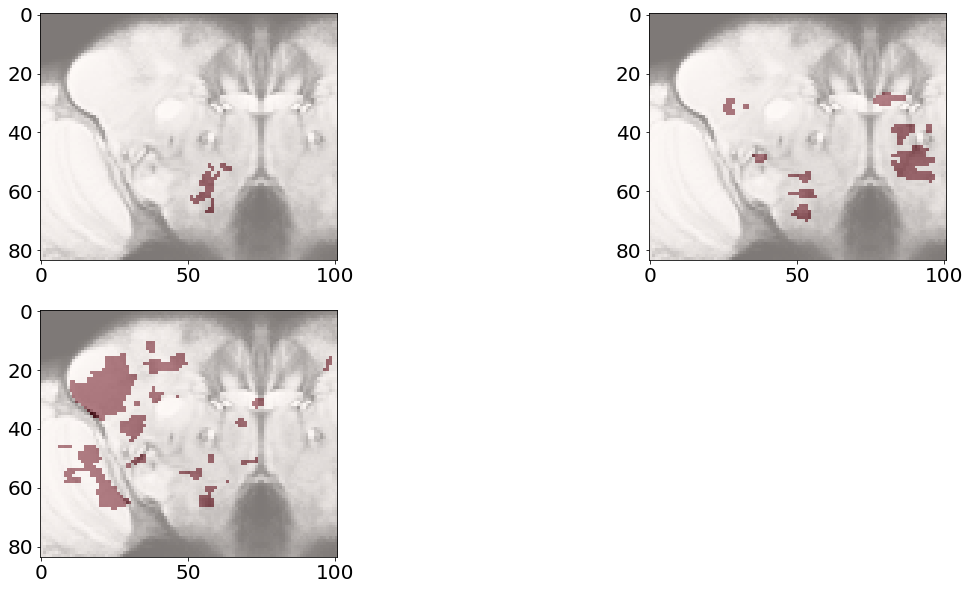

In [279]:
fig = plt.figure(figsize=(20,10))
z=23

plt.subplot(2,2,1)
plt.imshow(FDA_crop[:,:,z].T,cmap='Greys_r')
plt.imshow(DN_crop[:,:,z].T>0, alpha=.5, cmap='Reds')

plt.subplot(2,2,2)
plt.imshow(FDA_crop[:,:,z].T,cmap='Greys_r')
plt.imshow(out2[:,:,z].T, alpha=.5, cmap='Reds')

plt.subplot(2,2,3)
plt.imshow(FDA_crop[:,:,z].T,cmap='Greys_r')
plt.imshow(out3[:,:,z].T, alpha=.5, cmap='Reds')

In [ ]:
import pickle
file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20220624_supervoxels_in_FDA/hemibrain_all_neurons_synapses_polypre_centrifugal_synapses.pickle'
file = open(file, 'rb')
synapses = pickle.load(file)

In [25]:
synapses.keys()

dict_keys(['treenode_id', 'connector_id', 'prepost', 'x', 'y', 'z', 'confidence', 'bodyid', 'partner', 'inside', 'Label', 'old_xyz'])

In [ ]:
DNa01, ID: 1170939344, ipsilateral turning
DNa02, ID: 1140245595, ipsilateral turning
DNg13, ID: 1696530677, ipsilateral turning
DNb05, ID: 1406966879, ipsilateral turning (weakly)
DNb06, ID: 1715999506, contralateral turning (weakly)

In [70]:
idx = np.where(synapses['bodyid']=='5813024015')[0]
xs = synapses['x'][idx]
ys = synapses['y'][idx]
zs = synapses['z'][idx]

In [71]:
DN = np.histogramdd((xs*.38,ys*.38,zs*.38),
        bins=(np.arange(0,242*2.6,2.6), np.arange(0,113*2.6,2.6), np.arange(0,37*5,5)))[0]

DN_crop = DN[start['x']:stop['x'],
                  start['y']:stop['y'],
                  start['z']:stop['z']]

In [381]:
np.sum(hemi_vol), np.sum(out2), np.sum(out3), np.sum(DN_crop)

(75835.0, 6907.0, 10584.0, 1119.0)

In [368]:
for_sampling = np.zeros((int(np.sum(hemi_vol))))
for_sampling[:int(np.sum(out3))] = 1
np.sum(random.choices(for_sampling, k=int(np.sum(DN_crop))))

133.0

3345

In [336]:
np.sum(hemi_vol)-np.sum(DN_crop)

72490.0

In [326]:
# overlap_r = np.sum(np.logical_and(DN_crop>0, unique_crop[...,0]>0.005))
# overlap_l = np.sum(np.logical_and(DN_crop>0, unique_crop[...,1]>0.005))
# print(overlap_r, overlap_l) 

292 871


In [42]:
to_color = np.zeros((3000))
to_color[beh_scores['R']>.005] = 1
out2 = clusters_to_3d(to_color)

to_color = np.zeros((3000))
to_color[beh_scores['L']>.005] = 1
out3 = clusters_to_3d(to_color)

to_color = np.zeros((3000))
to_color[beh_scores['F']>.005] = 1
out4 = clusters_to_3d(to_color)

In [37]:
to_color = np.zeros((3000))
to_color[beh_scores['R']>.01] = 1
out2 = clusters_to_3d(to_color)

to_color = np.zeros((3000))
to_color[beh_scores['L']>.01] = 1
out3 = clusters_to_3d(to_color)

In [367]:
overlap_r = np.sum(np.logical_and(DN_crop>0, out2))
overlap_l = np.sum(np.logical_and(DN_crop>0, out3))
print(overlap_r, overlap_l) 

0 91


In [285]:
overlap_r = np.sum(np.logical_and(DN_crop>0, out2))
overlap_l = np.sum(np.logical_and(DN_crop>0, out3))
print(overlap_r, overlap_l) # want relatively high r

36 80


In [215]:
# out = np.histogramdd((xs,ys,zs),
#         bins=(np.arange(0,1653,1), np.arange(0,769,1), np.arange(0,480,1)))[0]

In [252]:
out.shape

(241, 112, 36)

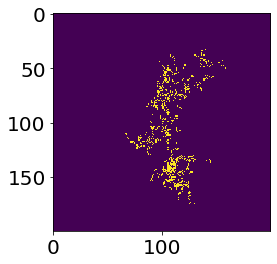

In [234]:
plt.imshow(np.max(out,axis=2).T[350:550,600:800]>0)

In [222]:
DN = ants.from_numpy(out)
DN.set_spacing((.38,.38,.38))
DN_lowres = ants.resample_image(DN,(2.6,2.6,5),use_voxels=False,interp_type=0)

In [158]:
plt.imshow((np.max(DN_crop,axis=2).T>0))

NameError: name 'DN_crop' is not defined

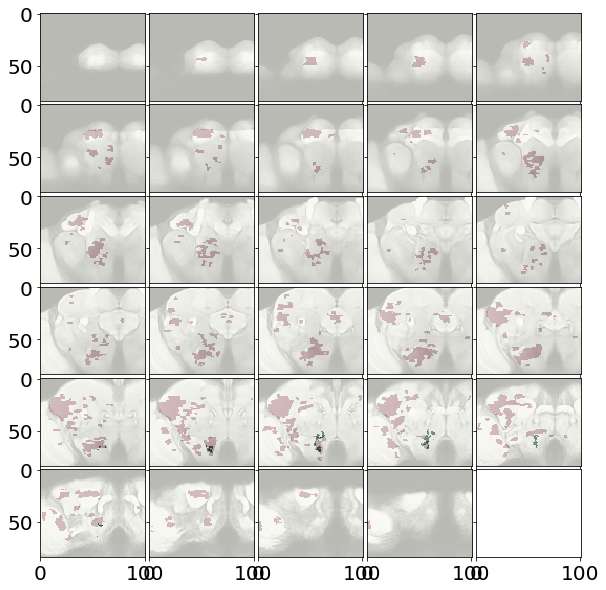

In [69]:
fig = plt.figure(figsize=(20,10))
grid = ImageGrid(fig, 111, nrows_ncols=(6, 5), axes_pad=.05)
for z in range(29):
    grid[z].imshow(FDA_crop[:,:,z].T,cmap='Greys_r')
    grid[z].imshow(out3[:,:,z].T>0, alpha=.5, cmap='Reds')
    grid[z].imshow(DN_crop[:,:,z].T>0, alpha=.5, cmap='Greens')

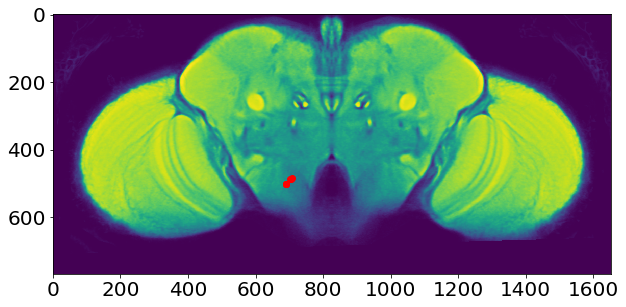

In [198]:
z=340
plt.figure(figsize=(10,10))
plt.imshow(FDA[:,:,z].T)
for i in range(len(xs)):
    if int(zs[i]) == z:
        plt.scatter(xs[i],ys[i],color='r')

In [174]:
479*.38

182.02

In [179]:
zs

array([270.31292172, 197.27753332, 252.90633043, ..., 230.78599014,
       230.78599014, 230.78599014])

In [180]:
ys

array([421.07043068, 346.87587483, 361.46492982, ..., 382.48917212,
       382.48917212, 382.48917212])

In [181]:
xs

array([720.40355837, 784.27572701, 728.09184268, ..., 750.2216578 ,
       750.2216578 , 750.2216578 ])

In [163]:
len(np.where(synapses['bodyid']=='1170939344')[0])

3345

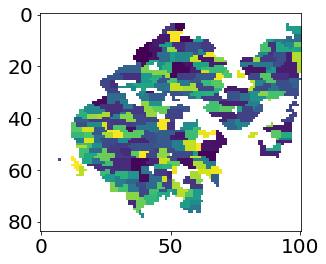

In [303]:
plt.imshow(labels_3d[:,:,12].T)

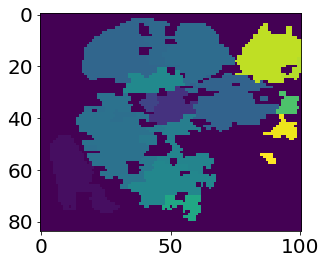

In [323]:
plt.imshow(out[:,:,16].T) #this is from below

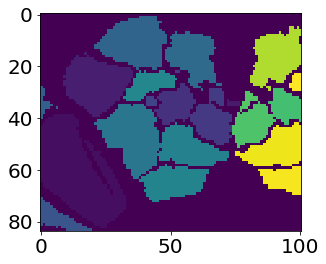

In [595]:
plt.imshow(atlas_crop[:,:,20].T)

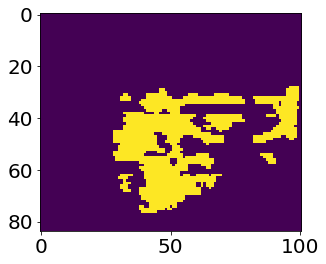

In [347]:
plt.imshow(out[:,:,16].T)

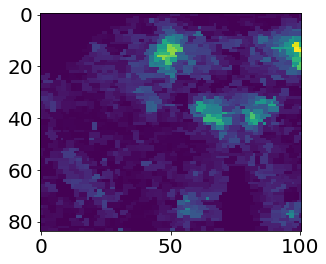

In [24]:
plt.imshow(unique_crop[:,:,16,2].T)

In [348]:
unique_crop.shape, atlas_cropped_to_hemi.shape

((101, 84, 29, 3), (101, 84, 29))

In [350]:
atlas_ids = [0] # cluster_num 0 doesn't exist in labels_3d
fwd_score = [0]
for cluster_num in range(1, n_clusters):
    indicies = np.where(labels_3d==cluster_num)
    
    atlas_roi_list = atlas_cropped_to_hemi[indicies]
    atlas_id = int(stats.mode(atlas_roi_list)[0])

    atlas_ids.append(atlas_id)
    fwd_score.append(np.mean(unique_crop[indicies]))

atlas_ids = np.asarray(atlas_ids)
fwd_score = np.asarray(fwd_score)

In [ ]:
# now for each supervoxel cluster i want to get an roi ID and its unique scores

In [30]:
beh_scores = {}
for beh in ['L', 'R', 'F']:
    if beh == 'L': idx = 1
    if beh == 'R': idx = 0
    if beh == 'F': idx = 2
    unique_crop = corr_map[start['x']:stop['x'],
                  start['y']:stop['y'],
                  start['z']:stop['z'],:]
    unique_crop = unique_crop[...,idx] #pick corr type here
    
    
    atlas_ids = [0] # cluster_num 0 doesn't exist in labels_3d
    beh_scores[beh] = [0]
    for cluster_num in range(1, n_clusters):
        indicies = np.where(labels_3d==cluster_num)

        atlas_roi_list = atlas_crop[indicies]
        atlas_id = int(stats.mode(atlas_roi_list)[0])

        ### only consider clusters that do not include more than 1 atlas roi ###
        # (0 is ok, so <3)
        if len(np.unique(atlas_roi_list)) < 3:
            atlas_ids.append(atlas_id)
            beh_scores[beh].append(np.mean(unique_crop[indicies]))
        else:
            atlas_ids.append(0)
            beh_scores[beh].append(0)
    atlas_ids = np.asarray(atlas_ids)
    beh_scores[beh] = np.asarray(beh_scores[beh])

In [51]:
beh_scores = {}
for beh in ['L', 'R', 'F']:
    if beh == 'L': idx = 1
    if beh == 'R': idx = 0
    if beh == 'F': idx = 2
    unique_crop = corr_map[start['x']:stop['x'],
                  start['y']:stop['y'],
                  start['z']:stop['z'],:]
    unique_crop = unique_crop[...,idx] #pick corr type here
    
    
    atlas_ids = [0] # cluster_num 0 doesn't exist in labels_3d
    beh_scores[beh] = [0]
    for cluster_num in range(1, n_clusters):
        indicies = np.where(labels_3d==cluster_num)

        atlas_roi_list = atlas_crop[indicies]
        atlas_id = int(stats.mode(atlas_roi_list)[0])

        ### only consider clusters that do not include more than 1 atlas roi ###
        # (0 is ok, so <3)
        #if len(np.unique(atlas_roi_list)) < 3:
        atlas_ids.append(atlas_id)
        beh_scores[beh].append(np.mean(unique_crop[indicies]))
#         else:
#             atlas_ids.append(0)
#             beh_scores[beh].append(0)
    atlas_ids = np.asarray(atlas_ids)
    beh_scores[beh] = np.asarray(beh_scores[beh])

In [49]:
np.sum(beh_scores['L']>.01)

136

In [50]:
np.sum(beh_scores['R']>.01)

66

In [661]:
roi_id_from=56
IPS_beh = np.logical_and(beh_scores['R']>.01, atlas_ids == roi_id_from)
np.sum(IPS_beh)

2

In [659]:
np.where(beh_scores['R']>.01)[0]

array([ 147,  189,  302,  327,  431,  453,  460,  519,  548,  692,  718,
        837,  892,  978, 1027, 1080, 1081, 1087, 1110, 1172, 1263, 1264,
       1284, 1285, 1343, 1425, 1462, 1476, 1489, 1545, 1546, 1573, 1613,
       1694, 1699, 1717, 1772, 1773, 1780, 1781, 1791, 1948, 2118, 2143,
       2209, 2233, 2310, 2342, 2351, 2425, 2468, 2483, 2510, 2519, 2593,
       2649, 2699, 2712, 2754, 2939, 2947, 2957, 2997])

In [645]:
np.where(IPS_beh)[0]

array([ 548,  692, 1027, 1087, 1284, 1462, 1546, 1613, 1773, 1780, 2468,
       2510, 2519, 2593, 2699, 2712])

In [634]:
np.where(IPS_beh)[0]

array([ 548,  692, 1027, 1087, 1284, 1462, 1546, 1613, 1773, 1780, 2468,
       2510, 2519, 2593, 2699, 2712])

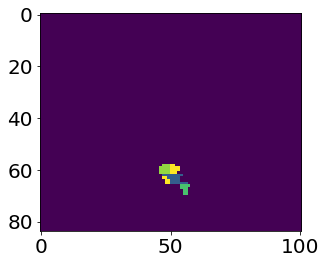

In [632]:
to_color = np.zeros((3000))
to_color[IPS_beh] = np.random.rand(np.sum(IPS_beh))
out = clusters_to_3d(to_color)
z=18
plt.imshow(out[:,:,z].T)

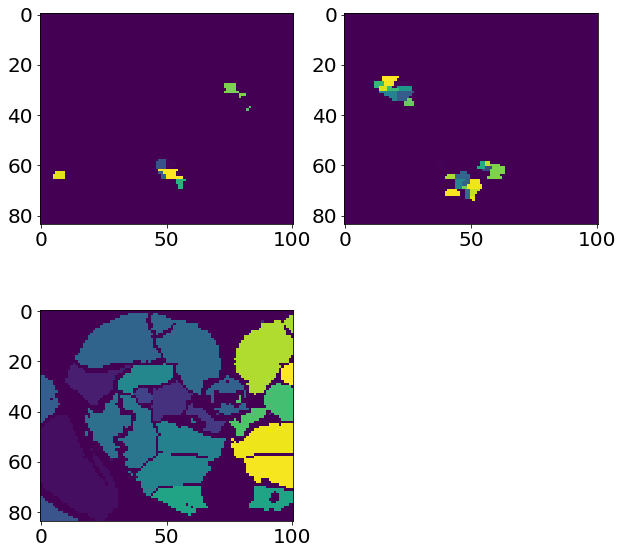

In [620]:
to_color = np.zeros((3000))
to_color[beh_scores['R']>.01] = np.random.rand(np.sum(beh_scores['R']>.01))
out_r = clusters_to_3d(to_color)

to_color = np.zeros((3000))
to_color[beh_scores['L']>.01] = np.random.rand(np.sum(beh_scores['L']>.01))
out_l = clusters_to_3d(to_color)
plt.figure(figsize=(10,10))
z=18
plt.subplot(2,2,1)
plt.imshow(out_r[:,:,z].T)
plt.subplot(2,2,2)
plt.imshow(out_l[:,:,z].T)
plt.subplot(2,2,3)
plt.imshow(atlas_crop[:,:,z].T)

In [725]:
roi_id_from=7 #8 is LAL_r
IPS_beh = np.logical_and(beh_scores['F']>.01, atlas_ids == roi_id_from)
np.sum(IPS_beh)

2

In [726]:
np.where(IPS_beh)[0]

array([ 140, 1754])

In [ ]:
85: 'EPA_L',
40: 'EPA_R',
34: 'AOTU_R',
7: 'LH_R', ## NICE THIS WORKS FOR L VS F
24: 'AL_R',

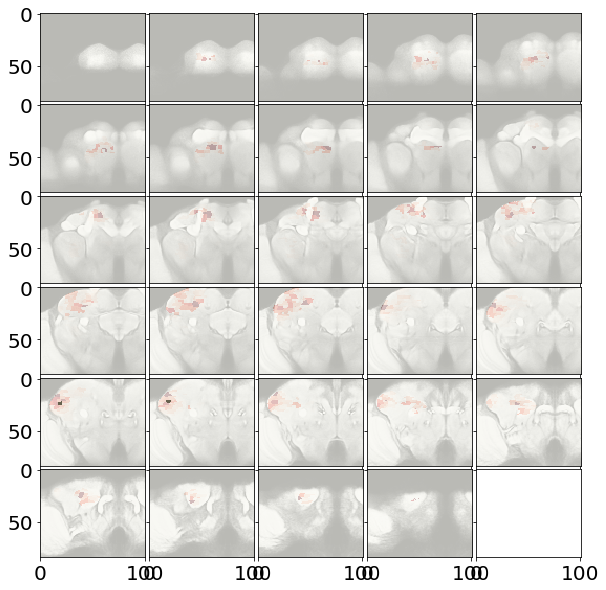

In [728]:
seed_cluster = 1754

visualize_seed = np.zeros(3000)
visualize_seed[seed_cluster] = 1
visualize_seed = clusters_to_3d(visualize_seed)

connectivity = adj[seed_cluster,:]
connectivity = clusters_to_3d(connectivity)

fig = plt.figure(figsize=(20,10))
grid = ImageGrid(fig, 111, nrows_ncols=(6, 5), axes_pad=.05)
for z in range(29):
    grid[z].imshow(FDA_crop[:,:,z].T,cmap='Greys_r')
    grid[z].imshow(connectivity[:,:,z].T, alpha=.5, cmap='Reds')
    grid[z].imshow(visualize_seed[:,:,z].T, alpha=.5, cmap='Greens')

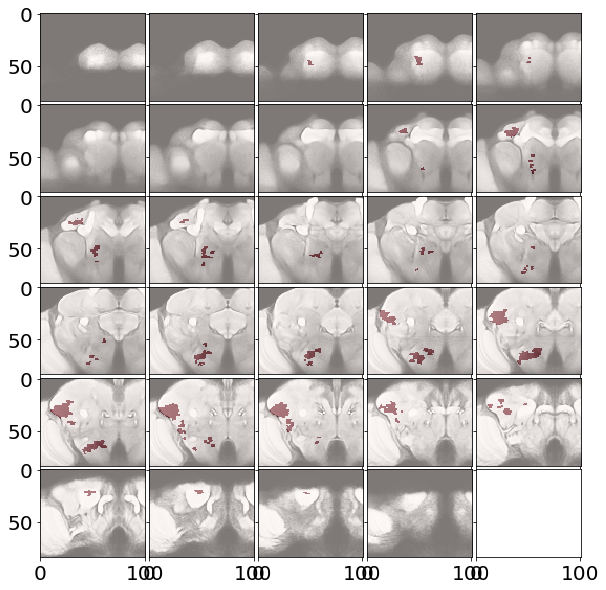

In [156]:
seed_cluster = 1754

temp = np.zeros(3000)
temp[beh_scores['L']>.01] = 1
beh = clusters_to_3d(temp)

fig = plt.figure(figsize=(20,10))
grid = ImageGrid(fig, 111, nrows_ncols=(6, 5), axes_pad=.05)
for z in range(29):
    grid[z].imshow(FDA_crop[:,:,z].T,cmap='Greys_r')
    grid[z].imshow(beh[:,:,z].T, alpha=.5, cmap='Reds')


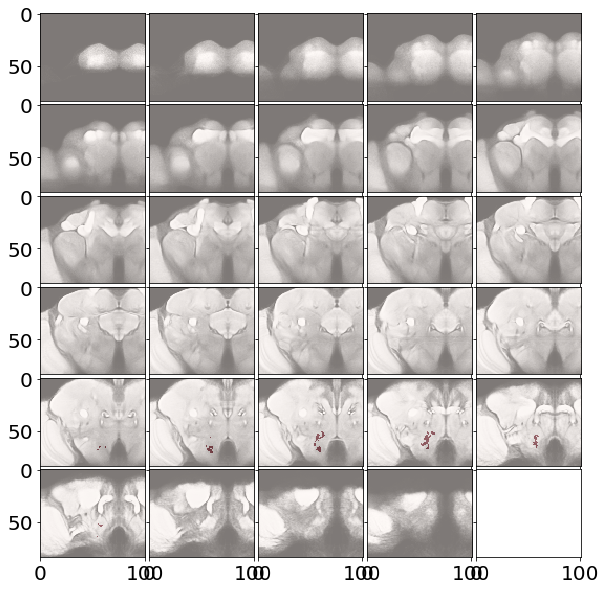

In [273]:
fig = plt.figure(figsize=(20,10))
grid = ImageGrid(fig, 111, nrows_ncols=(6, 5), axes_pad=.05)
for z in range(29):
    grid[z].imshow(FDA_crop[:,:,z].T,cmap='Greys_r')
    grid[z].imshow(DN_crop[:,:,z].T>0, alpha=.5, cmap='Reds')

In [ ]:
# can i show that beh_score correlates with subnetwork connectivity?
# 

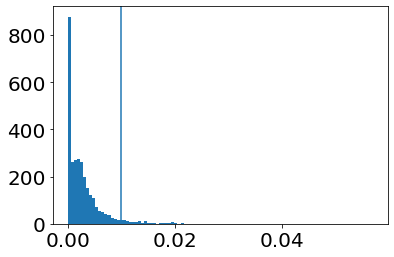

In [583]:
plt.hist(beh_scores['L'],bins=100);
plt.axvline(0.01)

In [503]:
threshold = 0.01
contains_beh = np.where(fwd_score > threshold)[0]
within_roi = np.where(atlas_ids != 0)[0]

In [504]:
len(within_roi), len(contains_beh)

(1904, 139)

In [448]:
len(within_roi), len(contains_beh)

(1904, 255)

In [505]:
subnetwork_voxels = np.intersect1d(contains_beh,  within_roi)
print(len(subnetwork_voxels))

134


In [526]:
labels_flat

(246036,)

In [507]:
to_color = np.zeros((3000))
to_color[subnetwork_voxels] = 1

In [508]:
out = clusters_to_3d(to_color)

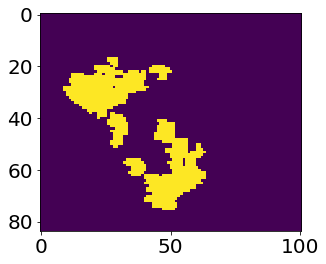

In [509]:
plt.imshow(np.max(out,axis=2).T)

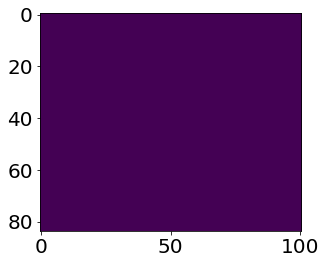

In [510]:
plt.imshow(out[:,:,7].T)

In [390]:
adj.shape

(3000, 3000)

In [374]:
roi_id = 26
roi_voxels = np.where(atlas_ids[subnetwork_voxels] == roi_id)[0]
sub_adj = adj[roi_voxels,:]
# sub_adj = sub_adj[:,subnetwork_voxels]
sub_adj.shape

(36, 3000)

0.1976739708608795 0.04029953280014011


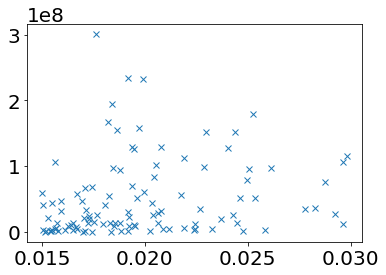

In [798]:
thresh = .015
beh = 'F'

subnetwork_voxels = np.where(beh_scores[beh] > thresh)[0]
adj_sub = adj[subnetwork_voxels,:]
adj_sub = adj_sub[:,subnetwork_voxels]
connectivity = np.sum(adj_sub,axis=1)

sub_scores = beh_scores[beh][subnetwork_voxels]
r, p = scipy.stats.pearsonr(sub_scores, connectivity)
plt.plot(sub_scores, connectivity, linestyle='', marker='x')
print(r,p)

In [789]:
thresh = .01
beh = 'L'
subnetwork_voxels = np.where(beh_scores[beh] > thresh)[0]
print(len(subnetwork_voxels))

cent = np.asarray(list(centrality.values()))[subnetwork_voxels]
np.mean(cent)

139


0.5881145033956163

In [790]:
np.mean(np.asarray(list(centrality.values())))

0.5702645326219851

In [383]:
thresh = .01
beh = 'F'

subnetwork_voxels = np.where(beh_scores[beh] > thresh)[0]
sub_scores = beh_scores[beh][subnetwork_voxels]

cent = np.asarray(list(centrality.values()))[subnetwork_voxels]

sub_scores = beh_scores[beh][subnetwork_voxels]
r, p = scipy.stats.pearsonr(sub_scores, cent)
plt.plot(sub_scores, cent, linestyle='', marker='x')
print(r,p)

NameError: name 'centrality' is not defined

In [780]:
list(centrality.values())

[0.0,
 0.33844614871623874,
 0.8602867622540846,
 0.7812604201400466,
 0.4331443814604868,
 0.4691563854618206,
 0.7039013004334778,
 0.8552850950316772,
 0.7759253084361454,
 0.5055018339446482,
 0.09736578859619872,
 0.324108036012004,
 0.47882627542514167,
 0.752917639213071,
 0.7715905301767255,
 0.6445481827275759,
 0.8399466488829609,
 0.2794264754918306,
 0.7065688562854284,
 0.6992330776925642,
 0.8236078692897632,
 0.6048682894298099,
 0.5708569523174392,
 0.7965988662887629,
 0.8222740913637879,
 0.4758252750916972,
 0.5668556185395132,
 0.32944314771590527,
 0.6152050683561187,
 0.5205068356118706,
 0.05468489496498832,
 0.24674891630543513,
 0.8189396465488495,
 0.6315438479493164,
 0.42614204734911637,
 0.7792597532510837,
 0.5518506168722908,
 0.6592197399133044,
 0.7102367455818606,
 0.8836278759586529,
 0.7879293097699233,
 0.7719239746582194,
 0.5778592864288096,
 0.6152050683561187,
 0.3861287095698566,
 0.737245748582861,
 0.3594531510503501,
 0.555185061687229,
 0.5

In [ ]:
centrality

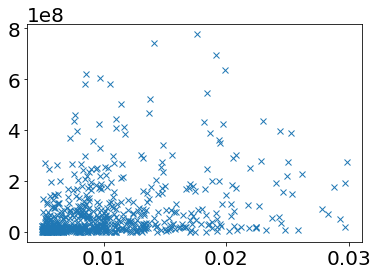

In [745]:
r,p

(0.30271574885302893, 1.873760711617759e-15)

In [738]:
connectivity.shape

(660,)

In [43]:
thresh = .01
beh = 'F'

subnetwork_voxels = np.where(beh_scores[beh] > thresh)[0]

unique_ids = np.unique(atlas_ids[subnetwork_voxels])[1:]
subnetwork_adj = np.empty((len(unique_ids), len(unique_ids)))

for j, roi_id_from in enumerate(unique_ids):
    roi_voxels_from = np.where(atlas_ids[subnetwork_voxels] == roi_id_from)[0]
    sub_adj = adj[roi_voxels_from,:]
    connectivity = []
    for roi_id_to in unique_ids:
        roi_voxels_to = np.where(atlas_ids[subnetwork_voxels] == roi_id_to)[0]
        connectivity.append(np.sum(sub_adj[:,roi_voxels_to]))
    subnetwork_adj[j,:] = connectivity

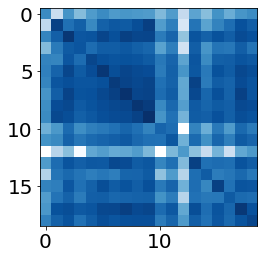

In [44]:
plt.imshow(subnetwork_adj,cmap='Blues',norm=mpl.colors.LogNorm())

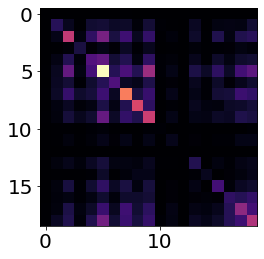

In [495]:
plt.imshow(subnetwork_adj,cmap='magma')#,norm=mpl.colors.LogNorm())

In [490]:
[full_group[i] for i in unique_ids]

['LH_R',
 'LAL_R',
 'CRE_R',
 'MB_PED_R',
 'MB_VL_R',
 'MB_ML_R',
 'AL_R',
 'FB',
 'SIP_R',
 'SMP_R',
 'AVLP_R',
 'MB_CA_R',
 'SCL_R',
 'GNG',
 'LAL_L',
 'CRE_L',
 'MB_VL_L',
 'MB_ML_L',
 'SMP_L']

In [401]:
subnetwork_adj.shape

(11, 11)

In [426]:
np.max(subnetwork_adj)

194584953.0

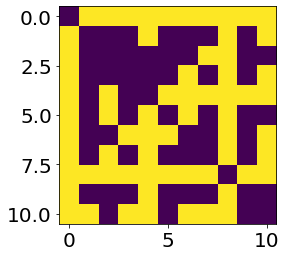

In [437]:
plt.imshow(adj_sub>1000000)

In [428]:
adj_sub = subnetwork_adj.copy()
np.fill_diagonal(adj_sub,0)

In [446]:
def drawArrow(A, B, width):
    w=width
    plt.arrow(A[0], A[1], B[0] - A[0], B[1] - A[1],
              head_width=w, length_includes_head=True,
              color='k', width=width)

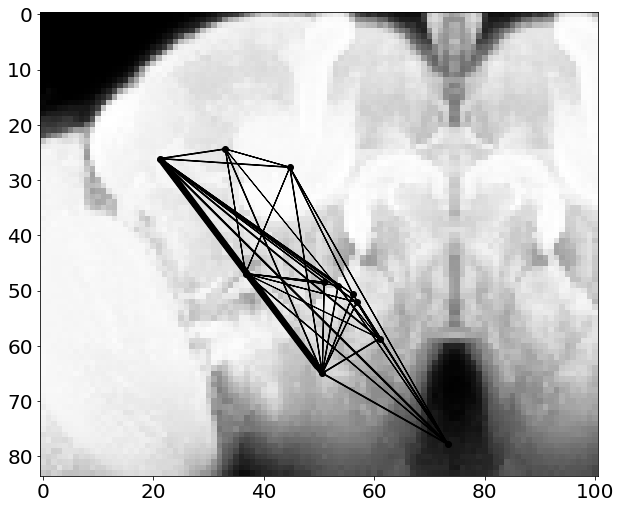

In [447]:
fig = plt.figure(figsize=(10,10))
plt.imshow(np.max(FDA_crop,axis=2).T,cmap='Greys_r')
#plt.imshow(np.max(colored,axis=2).T,alpha=.5)
conn_thresh = 1000000
distance_thresh = 0

adj_sub = subnetwork_adj.copy()
np.fill_diagonal(adj_sub,0)
max_con = np.max(adj_sub)

for idx1, i in enumerate(unique_ids):
    x1 = np.where(atlas_crop == i)[0].mean()
    y1 = np.where(atlas_crop == i)[1].mean()
    plt.scatter(x1,y1,color='k')
    for idx2, j in enumerate(unique_ids):
        x2 = np.where(atlas_crop == j)[0].mean()
        y2 = np.where(atlas_crop == j)[1].mean()
        width = adj_sub[idx1,idx2]/max_con
        if adj_sub[idx1,idx2] > conn_thresh:
            drawArrow((x1,y1),(x2,y2),width)
# for comb in itertools.combinations(supervoxels_yes, 2):
#     id1 = valid_clusters[comb[0]]
#     id2 = valid_clusters[comb[1]]
#     if adj[id1,id2] > conn_thresh:
#         x1 = (centroids[comb[0],:]/2.6)[0]
#         y1 = (centroids[comb[0],:]/2.6)[1]
#         x2 = (centroids[comb[1],:]/2.6)[0]
#         y2 = (centroids[comb[1],:]/2.6)[1]
        
#         x_dist = (centroids[comb[0],0] - centroids[comb[1],0])**2
#         y_dist = (centroids[comb[0],1] - centroids[comb[1],1])**2
#         z_dist = (centroids[comb[0],2] - centroids[comb[1],2])**2
#         dist = (x_dist + y_dist + z_dist)**.5
#         if dist > distance_thresh:
#             drawArrow((x1,y1),(x2,y2),.1)

In [537]:
np.sum(atlas_ids == roi_id_from)

96

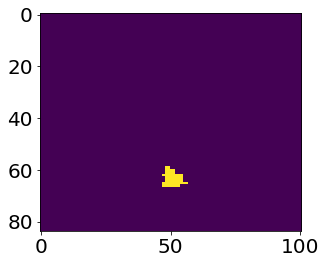

In [576]:
IPS_beh = np.logical_and(fwd_score>.015, atlas_ids == roi_id_from)
to_color = np.zeros((3000))
to_color[IPS_beh] = 1
out = clusters_to_3d(to_color)
plt.imshow(np.max(out,axis=2).T)

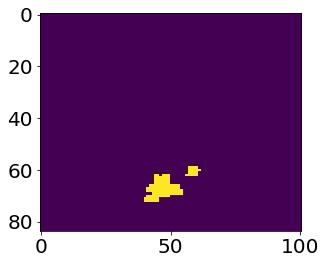

In [561]:
IPS_beh = np.logical_and(fwd_score>.015, atlas_ids == roi_id_from)
to_color = np.zeros((3000))
to_color[IPS_beh] = 1
out = clusters_to_3d(to_color)
plt.imshow(np.max(out,axis=2).T)

In [560]:
adj[c,:].shape

(15, 3000)

In [577]:
sub_adj = adj[IPS_beh,:]

unique_ids = np.unique(atlas_ids)[1:]
connectivity = {}
for roi_id_to in unique_ids:
    roi_voxels_to = np.where(atlas_ids == roi_id_to)[0]
    connectivity[full_group[roi_id_to]] = np.sum(sub_adj[:,roi_voxels_to])

In [568]:
unique_ids[1:]

array([ 3,  4,  6,  7,  8,  9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 22, 23,
       24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 49,
       56, 59, 60, 61, 62, 63, 65, 66, 70, 73, 74, 80, 82, 85])

In [ ]:
#green
'LAL_L': 148315.0,
'LAL_R': 29534436.0,
    
# red
'LAL_L': 52668.0,
'LAL_R': 20553213.0,

In [557]:
np.sum(fwd_score>.015), np.sum(atlas_ids == roi_id_from), np.sum(np.logical_and(fwd_score>.015, atlas_ids == roi_id_from))


(48, 96, 15)

34

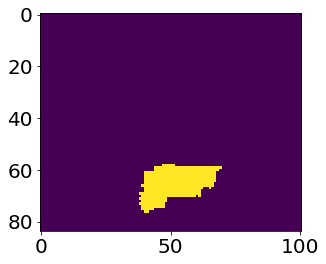

In [543]:
roi_id_from = 38
roi_voxels_from = atlas_ids == roi_id_from
to_color = np.zeros((3000))
to_color[roi_voxels_from] = 1
out = clusters_to_3d(to_color)
plt.imshow(np.max(out,axis=2).T)

In [538]:
to_color = np.zeros((3000))
to_color[roi_voxels_from] = 1

In [539]:
out = clusters_to_3d(to_color)

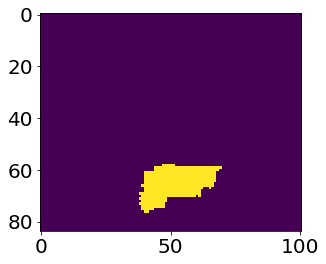

In [540]:
plt.imshow(np.max(out,axis=2).T)

In [ ]:
to_color = np.zeros((3000))
to_color[subnetwork_voxels] = 1

out = clusters_to_3d(to_color)

plt.imshow(np.max(out,axis=2).T)

In [527]:
roi_voxels

array([ 31,  58, 103, 112])

In [ ]:
cluster_indicies = np.where(labels_flat==cluster_num)[0]

In [525]:
indicies

array([ 31,  58, 103, 112])

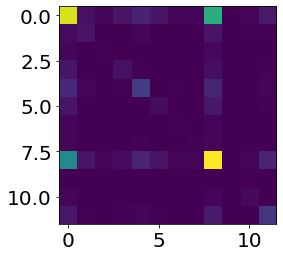

In [529]:
plt.imshow(subnetwork_adj)

In [457]:
subnetwork_adj_thresh = subnetwork_adj.copy()
subnetwork_adj_thresh[subnetwork_adj<20000000] = 0

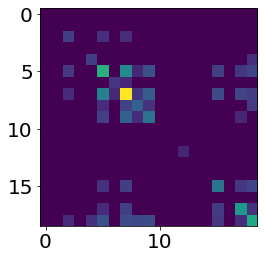

In [458]:
plt.imshow(subnetwork_adj_thresh)

In [515]:
[full_group[i] for i in unique_ids]

['LH_R',
 'LAL_R',
 'VES_R',
 'AL_R',
 'PLP_R',
 'AOTU_R',
 'MB_CA_R',
 'SPS_R',
 'IPS_R',
 'SCL_R',
 'EPA_R',
 'GNG']

In [467]:
list(unique_ids)

[7, 8, 16, 17, 18, 19, 24, 26, 28, 29, 30, 36, 49, 56, 59, 63, 65, 66, 74]

In [415]:
np.median(subnetwork_adj)

2158158.0

(array([469.,  42.,  13.,   2.,   1.,   0.,   1.,   0.,   0.,   1.]),
 array([0.00000000e+00, 3.36187064e+07, 6.72374128e+07, 1.00856119e+08,
        1.34474826e+08, 1.68093532e+08, 2.01712238e+08, 2.35330945e+08,
        2.68949651e+08, 3.02568358e+08, 3.36187064e+08]),
 <a list of 10 Patch objects>)

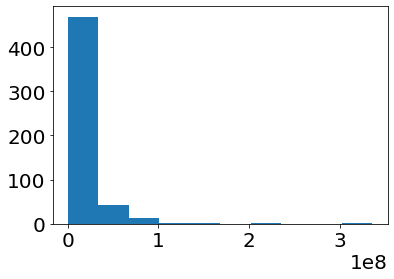

In [414]:
plt.hist(subnetwork_adj.flatten())

In [29]:
import networkx as nx
from fa2 import ForceAtlas2
import nxviz as nv
import matplotlib as mpl

In [620]:
G = nx.from_numpy_array(subnetwork_adj)

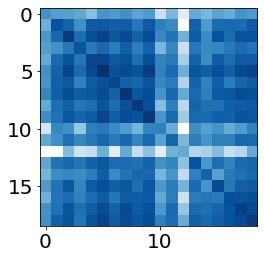

In [485]:
plt.imshow(subnetwork_adj,cmap='Blues',norm=mpl.colors.LogNorm())

In [523]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        edgeWeightInfluence=1,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,

                        # Tuning
                        scalingRatio=2, #How much repulsion you want. More makes a more sparse graph. Default=2
                        strongGravityMode=False,
                        gravity=1,#1.0,

                        # Log
                        verbose=True)

In [524]:
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=100)

100%|██████████| 100/100 [00:00<00:00, 9157.07it/s]

BarnesHut Approximation  took  0.00  seconds
Repulsion forces  took  0.00  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.00  seconds


(-40311.02175665266, 11997.1952550591, -61165.887951748125, 11145.75953180593)

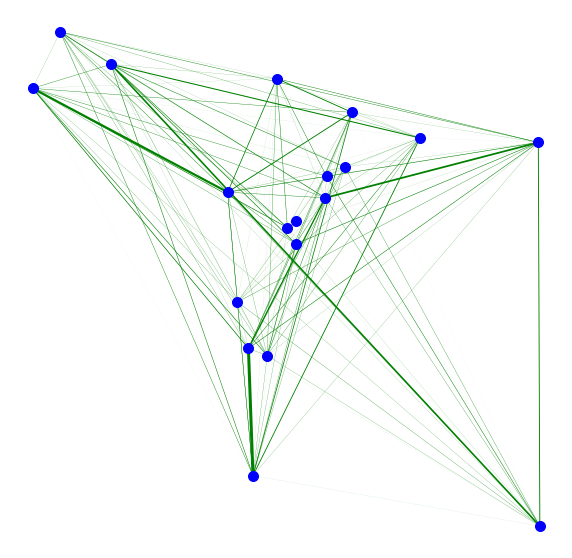

In [601]:
plt.figure(figsize=(10,10))
nx.draw_networkx_edges(G, positions, edge_color="green", alpha=1, 
                       width=3*subnetwork_adj.flatten()/subnetwork_adj.max())

nx.draw_networkx_nodes(G, positions, node_size=100, with_labels=True, node_color="blue", alpha=1)
plt.axis('off')


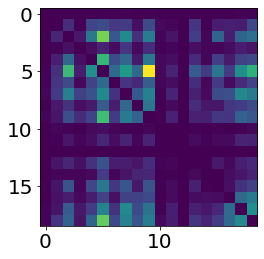

In [718]:
plt.imshow(adj_sub)

In [719]:
node_ids

{0: 'LH_R',
 1: 'LAL_R',
 2: 'CRE_R',
 3: 'MB_PED_R',
 4: 'MB_VL_R',
 5: 'MB_ML_R',
 6: 'AL_R',
 7: 'FB',
 8: 'SIP_R',
 9: 'SMP_R',
 10: 'AVLP_R',
 11: 'MB_CA_R',
 12: 'SCL_R',
 13: 'GNG',
 14: 'LAL_L',
 15: 'CRE_L',
 16: 'MB_VL_L',
 17: 'MB_ML_L',
 18: 'SMP_L'}

In [42]:
beh_scores['F'].shape

(3000,)

In [150]:
thresh = .01
beh = 'F'

subnetwork_voxels = np.where(beh_scores[beh] > thresh)[0]

unique_ids = np.unique(atlas_ids[subnetwork_voxels])[1:]
subnetwork_adj = np.empty((len(unique_ids), len(unique_ids)))

for j, roi_id_from in enumerate(unique_ids):
    roi_voxels_from = np.where(atlas_ids[subnetwork_voxels] == roi_id_from)[0]
    sub_adj = adj[roi_voxels_from,:]
    connectivity = []
    for roi_id_to in unique_ids:
        roi_voxels_to = np.where(atlas_ids[subnetwork_voxels] == roi_id_to)[0]
        connectivity.append(np.sum(sub_adj[:,roi_voxels_to]))
    subnetwork_adj[j,:] = connectivity

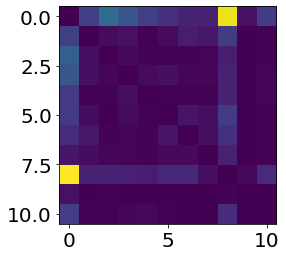

In [139]:
plt.imshow(adj_sub)

In [151]:
G = nx.from_numpy_array(subnetwork_adj)
adj_sub = subnetwork_adj.copy()
np.fill_diagonal(adj_sub,0)

con_thresh = 10000000

max_con = adj_sub.max()
edge_widths = {}
edge_alpha = {}
for i in range(np.shape(adj_sub)[0]):
    for j in range(np.shape(adj_sub)[0]):
        if adj_sub[i,j] > con_thresh:
            edge_widths[(i,j)] = 10*adj_sub[i,j]/max_con
            edge_alpha[(i,j)] = 1
        else:
            edge_widths[(i,j)] = 0 
            edge_alpha[(i,j)] = 0
nx.set_edge_attributes(G, edge_widths, 'edge_widths')
nx.set_edge_attributes(G, edge_alpha, 'edge_alpha')
node_ids = {k:full_group[i] for k,i in enumerate(unique_ids)}
G = nx.relabel_nodes(G, node_ids)

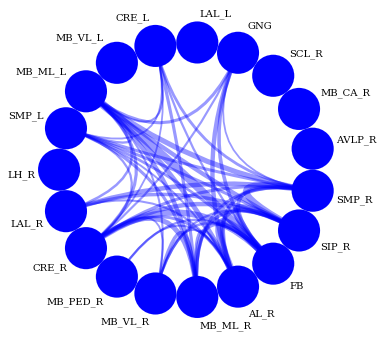

In [152]:
out = nv.CircosPlot(G,
                    edge_width='edge_widths',
                    node_labels=True)
out.edgeprops['alpha'] = .4
out.edge_colors = ['#0000FF'] * len(out.edges)
out.draw()

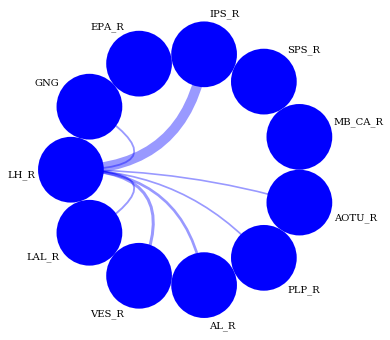

In [149]:
out = nv.CircosPlot(G,
                    edge_width='edge_widths',
                    node_labels=True)
out.edgeprops['alpha'] = .4
out.edge_colors = ['#0000FF'] * len(out.edges)
out.draw()

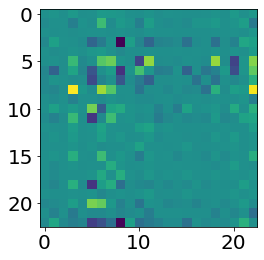

In [395]:
plt.imshow(subnetwork_adj - subnetwork_adj.T)

In [394]:
np.allclose(subnetwork_adj, subnetwork_adj.T)

False

In [384]:
unique_ids

array([ 7,  8,  9, 16, 17, 18, 19, 24, 26, 27, 28, 29, 30, 36, 39, 49, 56,
       59, 63, 65, 66, 73, 74])

In [385]:
roi_id_from

24

In [169]:
np.unique(np.asarray(atlas_ids)[subnetwork_voxels])

array([ 4,  8, 11, 12, 13, 14, 16, 17, 19, 23, 24, 26, 30, 31, 32, 33, 35,
       36, 37, 38, 40, 49, 56, 59, 60, 61, 63, 66, 70, 80, 82, 85])

In [176]:
np.unique(atlas_ids[subnetwork_voxels])

TypeError: only integer scalar arrays can be converted to a scalar index

In [370]:
np.unique(atlas_ids[subnetwork_voxels])

array([ 7,  8,  9, 16, 17, 18, 19, 24, 26, 27, 28, 29, 30, 36, 39, 49, 56,
       59, 63, 65, 66, 73, 74])

In [224]:
indicies = np.where(atlas_ids[subnetwork_voxels] == 26)[0]
np.sum(sub_adj[:,indicies])

74836964.0

In [241]:
connectivity = []
unique_ids = np.unique(atlas_ids[subnetwork_voxels])
for roi_id in unique_ids:
    indicies = np.where(atlas_ids[subnetwork_voxels] == roi_id)[0]
    connectivity.append(np.sum(sub_adj[:,indicies]))

In [412]:
connectivity = {}
unique_ids = np.unique(atlas_ids[subnetwork_voxels])
for roi_id in unique_ids:
    indicies = np.where(atlas_ids[subnetwork_voxels] == roi_id)[0]
    connectivity[full_group[roi_id]] = np.sum(sub_adj[:,indicies])

In [249]:
connectivity.items()

dict_items([('NO', 3684001.0), ('LAL_R', 48009260.0), ('AMMC_R', 17152001.0), ('ICL_R', 13186520.0), ('VES_R', 49231592.0), ('IB_R', 29347867.0), ('CRE_R', 6232370.0), ('MB_PED_R', 8007619.0), ('MB_ML_R', 3963794.0), ('EB', 13840499.0), ('AL_R', 100248527.0), ('FB', 74836964.0), ('AVLP_R', 100104762.0), ('PVLP_R', 7972789.0), ('IVLP_R', 18747710.0), ('PLP_R', 57257572.0), ('GOR_R', 2989678.0), ('MB_CA_R', 28132811.0), ('SPS_R', 95200958.0), ('IPS_R', 112838907.0), ('EPA_R', 3207682.0), ('GNG', 3915230.0), ('LAL_L', 3067623.0), ('ICL_L', 12115134.0), ('VES_L', 96496.0), ('IB_L', 54075660.0), ('CRE_L', 1996193.0), ('MB_ML_L', 4973781.0), ('AL_L', 5414503.0), ('GOR_L', 853008.0), ('SPS_L', 37283730.0), ('EPA_L', 164141.0)])

In [413]:
out = [(k, v) for k, v in sorted(connectivity.items(), key=lambda item: item[1])]
out

[('SCL_R', 451477.0),
 ('SAD', 1198471.0),
 ('ICL_L', 2125119.0),
 ('MB_VL_L', 2626998.0),
 ('MB_PED_R', 2778508.0),
 ('LAL_L', 3200383.0),
 ('GNG', 3313046.0),
 ('AVLP_R', 3521829.0),
 ('LH_R', 3705892.0),
 ('SLP_R', 4601023.0),
 ('SIP_L', 5953553.0),
 ('MB_CA_R', 15086744.0),
 ('LAL_R', 16124941.0),
 ('AL_R', 16530801.0),
 ('MB_VL_R', 31221891.0),
 ('SIP_R', 31318353.0),
 ('CRE_L', 40817146.0),
 ('CRE_R', 41723396.0),
 ('MB_ML_L', 51731314.0),
 ('FB', 60896324.0),
 ('SMP_R', 64521610.0),
 ('MB_ML_R', 73728203.0),
 ('SMP_L', 146597040.0)]

In [372]:
connectivity

{'AL_R': 31751923.0,
 'AVLP_R': 2100792.0,
 'CRE_L': 67584745.0,
 'CRE_R': 60618189.0,
 'FB': 211601209.0,
 'GNG': 4956188.0,
 'ICL_L': 2631469.0,
 'LAL_L': 4355301.0,
 'LAL_R': 12045186.0,
 'LH_R': 3861418.0,
 'MB_CA_R': 7057765.0,
 'MB_ML_L': 76652689.0,
 'MB_ML_R': 78422677.0,
 'MB_PED_R': 14295420.0,
 'MB_VL_L': 3556068.0,
 'MB_VL_R': 52097098.0,
 'SAD': 1275400.0,
 'SCL_R': 1787852.0,
 'SIP_L': 2868011.0,
 'SIP_R': 29172732.0,
 'SLP_R': 4578853.0,
 'SMP_L': 75319306.0,
 'SMP_R': 76917934.0}

In [236]:
connectivity[11]

74836964.0

In [215]:
unique_ids[np.argsort(connectivity)]

array([60, 85, 80, 63, 35, 56, 40,  4, 49, 19, 66, 70, 16, 31, 17, 59, 12,
       23, 11, 32, 36, 14, 82,  8, 13, 61, 33, 26, 37, 30, 24, 38])

In [219]:
full_group[37]

'SPS_R'

In [ ]:
85: 'EPA_L',
    40: 'EPA_R',

In [31]:
full_group = {
26: 'FB',
4: 'NO',
5: 'BU_R',
54: 'BU_L',
8: 'LAL_R',
56: 'LAL_L',
31: 'PVLP_R',
76: 'PVLP_L',
6: 'PB',
23: 'EB',
13: 'VES_R',  
40: 'EPA_R',
35: 'GOR_R',
11: 'AMMC_R',
60: 'VES_L', 
85: 'EPA_L',
80: 'GOR_L',
58: 'AMMC_L',
50: 'PRW',
9: 'SAD',
49: 'GNG',
30: 'AVLP_R',
75: 'AVLP_L',
24: 'AL_R',
70: 'AL_L',
64: 'MB_PED_L',
65: 'MB_VL_L',
66: 'MB_ML_L',
81: 'MB_CA_L',
17: 'MB_PED_R',
18: 'MB_VL_R',
19: 'MB_ML_R',
36: 'MB_CA_R',
32: 'IVLP_R',
77: 'IVLP_L',
10: 'CAN_R',
20: 'FLA_R',
57: 'CAN_L',
67: 'FLA_L',
27: 'SLP_R',
29: 'SMP_R',
33: 'PLP_R',
7: 'LH_R',
38: 'IPS_R',
37: 'SPS_R',
16: 'CRE_R',
39: 'SCL_R',
12: 'ICL_R',
15: 'ATL_R',
14: 'IB_R',
28: 'SIP_R',#####
72: 'SLP_L',   
74: 'SMP_L',
78: 'PLP_L',
55: 'LH_L',
83: 'IPS_L',
82: 'SPS_L',
63: 'CRE_L',
84: 'SCL_L',  
59: 'ICL_L',
62: 'ATL_L',
61: 'IB_L',
73: 'SIP_L',
25: 'MED_R',
3: 'LO_R',
22: 'LP_R',
34: 'AOTU_R',
71: 'MED_L',
53: 'LO_L',
69: 'LP_L',
79: 'AOTU_L',
}

(array([13.,  2.,  2.,  5.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([1.27540000e+06, 2.23079809e+07, 4.33405618e+07, 6.43731427e+07,
        8.54057236e+07, 1.06438304e+08, 1.27470885e+08, 1.48503466e+08,
        1.69536047e+08, 1.90568628e+08, 2.11601209e+08]),
 <a list of 10 Patch objects>)

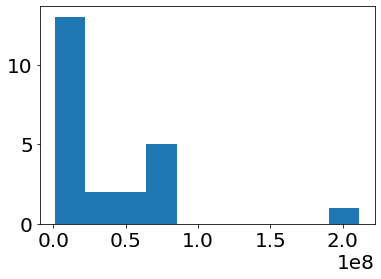

In [373]:
plt.hist(sorted(connectivity.values()))

In [204]:
sorted_dict = {}
sorted_keys = sorted(connectivity, key=connectivity.get)  # [1, 3, 2]
for w in sorted_keys:
    sorted_dict[w] = connectivity[w]

In [208]:
marklist = sorted(connectivity.items(), key=lambda x:x[1])
sortdict = dict(marklist)
sortdict

{4: 3684001.0,
 8: 48009260.0,
 11: 17152001.0,
 12: 13186520.0,
 13: 49231592.0,
 14: 29347867.0,
 16: 6232370.0,
 17: 8007619.0,
 19: 3963794.0,
 23: 13840499.0,
 24: 100248527.0,
 26: 74836964.0,
 30: 100104762.0,
 31: 7972789.0,
 32: 18747710.0,
 33: 57257572.0,
 35: 2989678.0,
 36: 28132811.0,
 37: 95200958.0,
 38: 112838907.0,
 40: 3207682.0,
 49: 3915230.0,
 56: 3067623.0,
 59: 12115134.0,
 60: 96496.0,
 61: 54075660.0,
 63: 1996193.0,
 66: 4973781.0,
 70: 5414503.0,
 80: 853008.0,
 82: 37283730.0,
 85: 164141.0}

In [206]:
connectivity

{4: 3684001.0,
 8: 48009260.0,
 11: 17152001.0,
 12: 13186520.0,
 13: 49231592.0,
 14: 29347867.0,
 16: 6232370.0,
 17: 8007619.0,
 19: 3963794.0,
 23: 13840499.0,
 24: 100248527.0,
 26: 74836964.0,
 30: 100104762.0,
 31: 7972789.0,
 32: 18747710.0,
 33: 57257572.0,
 35: 2989678.0,
 36: 28132811.0,
 37: 95200958.0,
 38: 112838907.0,
 40: 3207682.0,
 49: 3915230.0,
 56: 3067623.0,
 59: 12115134.0,
 60: 96496.0,
 61: 54075660.0,
 63: 1996193.0,
 66: 4973781.0,
 70: 5414503.0,
 80: 853008.0,
 82: 37283730.0,
 85: 164141.0}

In [201]:
{k: v for k, v in sorted(connectivity.items(), key=lambda item: item[1])}

{4: 3684001.0,
 8: 48009260.0,
 11: 17152001.0,
 12: 13186520.0,
 13: 49231592.0,
 14: 29347867.0,
 16: 6232370.0,
 17: 8007619.0,
 19: 3963794.0,
 23: 13840499.0,
 24: 100248527.0,
 26: 74836964.0,
 30: 100104762.0,
 31: 7972789.0,
 32: 18747710.0,
 33: 57257572.0,
 35: 2989678.0,
 36: 28132811.0,
 37: 95200958.0,
 38: 112838907.0,
 40: 3207682.0,
 49: 3915230.0,
 56: 3067623.0,
 59: 12115134.0,
 60: 96496.0,
 61: 54075660.0,
 63: 1996193.0,
 66: 4973781.0,
 70: 5414503.0,
 80: 853008.0,
 82: 37283730.0,
 85: 164141.0}

In [179]:
connectivity

{4: 3684001.0,
 8: 48009260.0,
 11: 17152001.0,
 12: 13186520.0,
 13: 49231592.0,
 14: 29347867.0,
 16: 6232370.0,
 17: 8007619.0,
 19: 3963794.0,
 23: 13840499.0,
 24: 100248527.0,
 26: 74836964.0,
 30: 100104762.0,
 31: 7972789.0,
 32: 18747710.0,
 33: 57257572.0,
 35: 2989678.0,
 36: 28132811.0,
 37: 95200958.0,
 38: 112838907.0,
 40: 3207682.0,
 49: 3915230.0,
 56: 3067623.0,
 59: 12115134.0,
 60: 96496.0,
 61: 54075660.0,
 63: 1996193.0,
 66: 4973781.0,
 70: 5414503.0,
 80: 853008.0,
 82: 37283730.0,
 85: 164141.0}

In [129]:
len(np.where(np.asarray(fwd_score)>.0001)[0])

2142

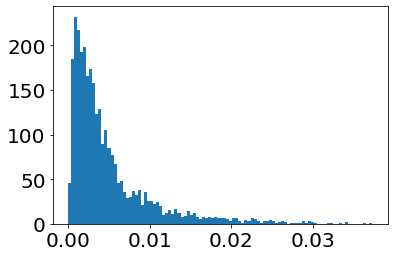

In [356]:
plt.hist(fwd_score,bins=100);

In [122]:
len(atlas_ids)

3000

In [110]:
np.bincount(atlas_ids)

array([372,   0,   0, 182,   2,   0,   7, 106,  35,   4,   0,   6,  33,
        27,  35,   2,  26,  11,  20,  56,   0,   0,   7,  20,  91,   0,
        68, 120,  29, 120, 208,  50,  15,  64,  18,   5,  33,  76,  96,
        25,   2,   0,   0,   0,   0,   0,   0,   0,   0,  18,   0,   0,
         0,   0,   0,   0,   8,   0,   0,  16,   1,  37,   3,  16,   0,
         8,  31,   0,   0,   0,   8,   0,   0,   2, 107,   0,   0,   0,
         0,   0,   2,   0,  47,   0,   0,   1])

In [113]:
np.sum(np.asarray(atlas_ids) != 0)

1904

In [101]:
np.sum(np.asarray(atlas_ids) != 0)

2292

In [83]:
def clusters_to_3d(neural_signals):
    colored = np.zeros((dim_c['x']*dim_c['y']*dim_c['z']))
    for cluster_num in range(n_clusters):
        cluster_indicies = np.where(labels_flat==cluster_num)[0]
        colored[cluster_indicies] = neural_signals[cluster_num]
    colored = np.reshape(colored,(dim_c['x'],dim_c['y'],dim_c['z']))
    return colored

In [84]:
out = clusters_to_3d(atlas_ids)

In [98]:
out[out==0] = np.nan

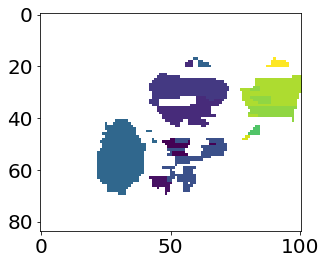

In [99]:
plt.imshow(out[:,:,7].T)

In [72]:
atlas_cropped_to_hemi[np.where(labels_3d==cluster_num)]

array([], dtype=float32)

In [73]:
cluster_num

0